<a href="https://colab.research.google.com/github/nathaliaferino/PIBIC---AN-OVERVIEW-OF-THE-USE-OF-ARTIFICIAL-NEURAL-NETWORKS-IN-QUANTUM-INFORMATION/blob/main/RNA_TOMOGRAFIA_DE_ESTADOS_QU%C3%82NTICOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import math
import random
from google.colab import files

In [ ]:
#Dados de treino
freq = pd.read_csv('/content/drive/MyDrive/GITHUB/Tomografia de Estados Quânticos/freq_amostral.csv', header=None).to_numpy()
prob = pd.read_csv('/content/drive/MyDrive/GITHUB/Tomografia de Estados Quânticos/prob_teorica.csv', header=None).to_numpy()
dados_treino = np.vstack((freq, prob))

#Dados de teste
dados_teste = pd.read_csv('/content/drive/MyDrive/GITHUB/Tomografia de Estados Quânticos/teste_freq.csv', header=None).to_numpy()

#Executando o código no CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Misturando os pontos e retirando qualquer viés da tabela de dados que possa vir existir
np.random.shuffle(dados_treino)
np.random.shuffle(dados_teste)

p = dados_treino[:,3:9] #[p_x+, p_x-, p_y+, p_y-, p_z+, p_z-]
p_validar = dados_teste[:,3:9]


sc = StandardScaler()
p = sc.fit_transform(p)
p_validar = sc.transform(p_validar)
p = torch.tensor(p, dtype=torch.float32, device=device)
p_validar = torch.tensor(p_validar, dtype=torch.float32, device=device)

r = torch.tensor(dados_treino[:, 0:3], dtype=torch.float32, device=device) #[x, y, z]
r_validar = torch.tensor(dados_treino[:, 0:3], dtype=torch.float32, device=device)
num_medidas = torch.tensor(dados_teste[:,9], dtype=torch.float32, device=device)

In [ ]:
#Estrutura da RNA

class RNAVetorBloch(nn.Module):
    def __init__(self):
        super(RNAVetorBloch, self).__init__()

        # Camada de entrada (probabilidades nas bases)
        self.linear1 = nn.Linear(6, 200)

        # Camadas ocultas
        self.linear2 = nn.Linear(200, 180)
        self.linear3 = nn.Linear(180, 180)
        self.linear4 = nn.Linear(180, 160)
        self.linear5 = nn.Linear(160, 160)
        self.linear6 = nn.Linear(160, 160)
        self.linear7 = nn.Linear(160, 160)
        self.linear8 = nn.Linear(160, 100)

        # Camada de saída (vetor de Bloch)
        self.output = nn.Linear(100, 3)

    def forward(self, x):
        # Entrada
        x = self.linear1(x) #F.relu(self.linear1(x)) se tivesse função de ativação ReLU

        # Camadas ocultas com ReLU
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        x = F.relu(self.linear7(x))
        x = F.relu(self.linear8(x))

        # Camada de saída com tanh
        y_predicted = torch.tanh(self.output(x))
        return y_predicted

#Otimizador e função custo
model = RNAVetorBloch().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-7
)

In [ ]:
def calcula_matriz_densidade(bloch_vector):
  # Matrizes de Pauli
  sigma_x = np.array([[0, 1], [1, 0]])
  sigma_y = np.array([[0, -1j], [1j, 0]])
  sigma_z = np.array([[1, 0], [0, -1]])
  matriz_densidade = np.zeros((2, 2))
  matriz_densidade = (1/2)*(np.eye(2) + bloch_vector[0]*sigma_x + bloch_vector[1]*sigma_y + bloch_vector[2]*sigma_z)
  return matriz_densidade

def Dist_Hilbert_Schmidt(rho_pred, rho_real):
  A = rho_pred - rho_real
  A_dager = np.conjugate(A.T)
  distancia = math.sqrt(np.trace(A_dager@A))
  return distancia

# Selecionando aleatoriamente 50 pontos entre todos os dados
num_pontos_dhs = p.shape[0]
indices_dhs = random.sample(range(p.shape[0]), num_pontos_dhs)
p_dhs = p[indices_dhs]
r_dhs = r[indices_dhs]

# Armazenamento para plot
epocas_registradas = []
dhs_medias = []

In [ ]:
#Loop de treino
num_epochs = 2000 #número de épocas
lote_tam = 1000 #tamanho do lote
num_lotes = p.shape[0] // lote_tam #quantidade de lotes
losses = [] # perdas por época

for epoch in range(num_epochs):
    epoch_loss, epoch_dhs = 0.0, 0.0

    for i in range(num_lotes):
        prob_lote = p[i*lote_tam:(i+1)*lote_tam]
        r_lote= r[i*lote_tam:(i+1)*lote_tam]

        # Forward
        r_pred = model(prob_lote)

        # Loss
        loss = criterion(r_pred, r_lote)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # calcula a perda média da época
    epoch_loss = epoch_loss / num_lotes
    losses.append(epoch_loss)

    # A cada 10 épocas, calculamos DHS apenas para os pontos selecionados
    if (epoch + 1) % 20 == 0:
        dhs_total = 0.0
        r_pred_dhs = model(p_dhs)

        for j in range(num_pontos_dhs):
            rho_pred_j = calcula_matriz_densidade(r_pred_dhs[j].cpu().detach().numpy())
            rho_real_j = calcula_matriz_densidade(r_dhs[j].cpu().detach().numpy())
            dhs_total += Dist_Hilbert_Schmidt(rho_pred_j, rho_real_j)

        dhs_media = dhs_total / num_pontos_dhs
        dhs_medias.append(dhs_media)
        epocas_registradas.append(epoch + 1)

/tmp/ipython-input-2056875992.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  distancia = math.sqrt(np.trace(A_dager@A))


/tmp/ipython-input-3692760605.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


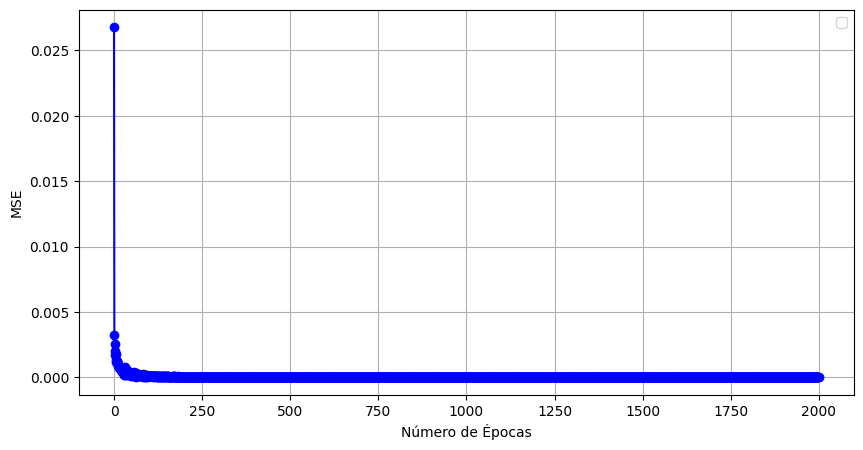

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.xlabel("Número de Épocas")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

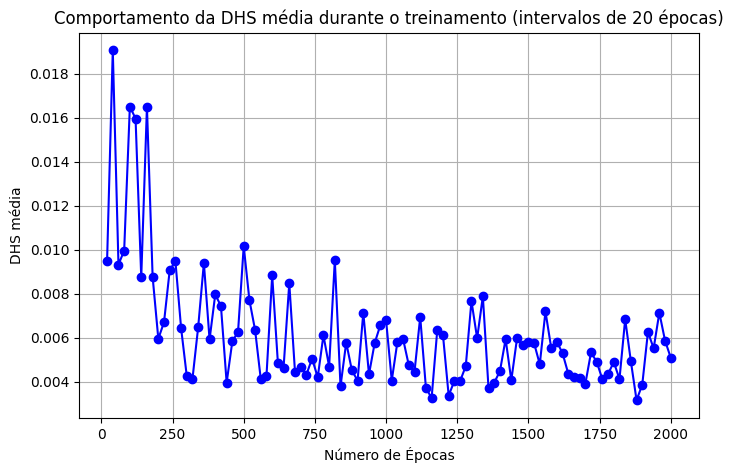

In [ ]:
#Plot da média da distância de Hilbert Shimidt para os dados de treino
plt.figure(figsize=(8,5))
plt.plot(epocas_registradas, dhs_medias, marker='o', linestyle='-', color='blue')
plt.xlabel('Número de Épocas')
plt.ylabel('DHS média')
plt.title('Comportamento da DHS média durante o treinamento (intervalos de 20 épocas)')
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    r_pred_val = model(p_validar.to(device))

r_validar = torch.tensor(dados_teste[:, 0:3], dtype=torch.float32, device=device)

# Calcula erro MSE
loss_val = criterion(r_pred_val, r_validar)

# Distância Hilbert–Schmidt
DHS_validar = []
for j in range(len(p_validar)):
    rho_pred = calcula_matriz_densidade(r_pred_val[j].cpu().numpy())
    rho_real = calcula_matriz_densidade(r_validar[j].cpu().numpy())
    dhs_valida = Dist_Hilbert_Schmidt(rho_pred, rho_real)
    DHS_validar.append(dhs_valida)

DHS_validar = np.array(DHS_validar)

/tmp/ipython-input-2056875992.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  distancia = math.sqrt(np.trace(A_dager@A))


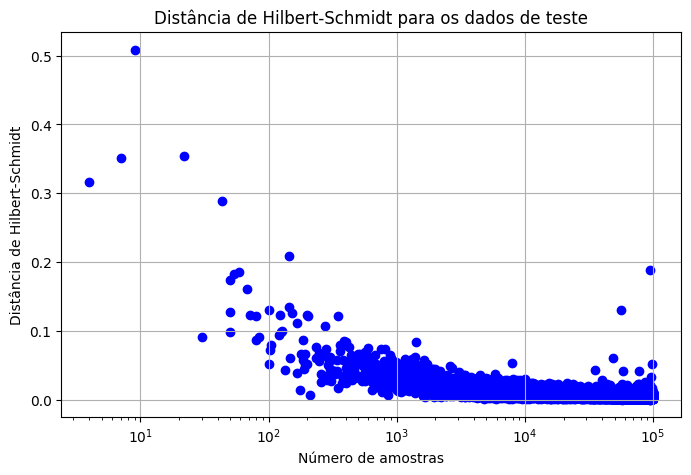

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(num_medidas, DHS_validar, color='blue')
plt.xscale('log')
plt.xlabel('Número de amostras')
plt.ylabel('Distância de Hilbert-Schmidt')
plt.title('Distância de Hilbert-Schmidt para os dados de teste')
plt.grid(True)
plt.show()